# KDE(Kernel Density Estimation)의 이해
## seaborn의 distplot()을 이용하여 KDE 시각화

In [10]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
sns.set(color_codes=True)

In [4]:
np.random.seed(0)
x = np.random.normal(0, 1, size=30)

In [5]:
print(x)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
  2.26975462 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877]


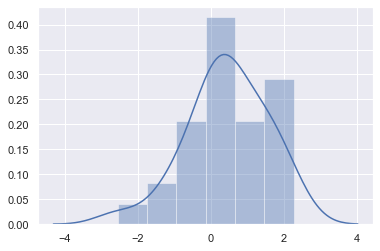

In [6]:
sns.distplot(x)

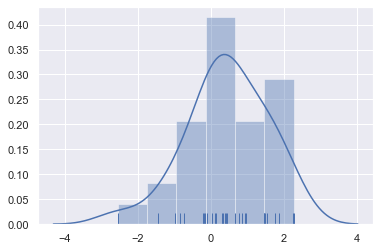

In [7]:
sns.distplot(x, rug=True)

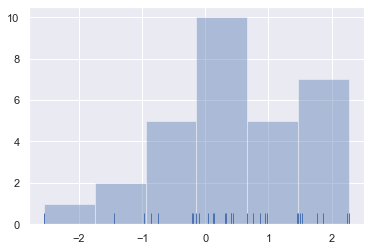

In [8]:
sns.distplot(x, kde=False, rug=True)

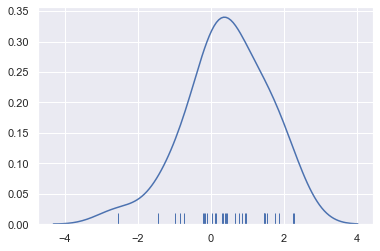

In [9]:
sns.distplot(x, hist=False, rug=True)

## 개별 관측데이터에 대해 가우시안 커널 함수를 적용